In [7]:
import numpy as np
import pandas as pd
import os
import torch

from pytorch_widedeep.preprocessing import WidePreprocessor, DeepPreprocessor, TextPreprocessor, ImagePreprocessor
from pytorch_widedeep.models import Wide, DeepDense, DeepText, DeepImage, WideDeep
from pytorch_widedeep.initializers import *
from pytorch_widedeep.callbacks import *
from pytorch_widedeep.optim import RAdam

In [8]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm
from sklearn.preprocessing import normalize
from scipy import sparse
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
dataset = pd.read_csv("merged_data.csv")

In [11]:
dataset_small=pd.read_csv("merged_data_small.csv")
dataset=dataset[dataset_small.columns]

In [12]:
test_dataset = dataset[dataset.groupby('user_id')['date'].transform('max') == dataset['date']].reset_index(drop=True)
print("test dataset created")
train_dataset = pd.concat([dataset, test_dataset]).drop_duplicates(keep=False).reset_index(drop=True)
print("train dataset created")

test dataset created
train dataset created


In [13]:
already_dummies=list(train_dataset.columns)[34:-11]+list(train_dataset.columns)[-10:]

In [14]:
wide_cols=['is_open']+already_dummies

In [15]:
train_dataset[wide_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400019 entries, 0 to 400018
Columns: 442 entries, is_open to casual
dtypes: int64(442)
memory usage: 1.3 GB


In [16]:
test_dataset[wide_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Columns: 442 entries, is_open to casual
dtypes: int64(442)
memory usage: 125.2 MB


In [17]:
target_col = 'rating'

In [18]:
target = train_dataset[target_col].values

In [19]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols)
X_wide_train = wide_preprocessor.fit_transform(train_dataset)
X_wide_test = wide_preprocessor.transform(test_dataset)

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [20]:
cat_embed_cols = [(c, 16) for c in train_dataset.columns if 'city' in c]

In [21]:
continuous_cols = ['useful',
 'funny',
 'cool',
 'fans',
 'avg_user_rating',
 'compliment_hot',
 'compliment_more',
 'compliment_profile',
 'compliment_cute',
 'compliment_list',
 'compliment_note',
 'compliment_plain',
 'compliment_funny',
 'compliment_writer',
 'compliment_photos',
 'years_elite',
'review_cnt_x','review_cnt_y']

In [22]:
deep_preprocessor = DeepPreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols)
X_deep_train = deep_preprocessor.fit_transform(train_dataset)
X_deep_test = deep_preprocessor.fit_transform(test_dataset) 

In [23]:
def deep_function(list1,list2):

    # Linear model
    wide = Wide(wide_dim=X_wide_train.shape[1], output_dim=1)
    # DeepDense: 2 Dense layers
    deepdense = DeepDense(hidden_layers=list1, dropout=list2,batchnorm=True, 
                      deep_column_idx=deep_preprocessor.deep_column_idx,
                      embed_input=deep_preprocessor.embeddings_input,
                      continuous_cols=continuous_cols)
    
    model = WideDeep(wide=wide, deepdense=deepdense)
    model.compile(method='regression')
    model.fit(X_wide=X_wide_train, X_deep=X_deep_train,target=target, n_epochs=5, batch_size=64, val_split=0.3)
    
    return(model)

In [24]:
model_1=deep_function([32,32],[0.5,0.5])
model_2=deep_function([32,64],[0.5,0.5])
model_3=deep_function([64,64],[0.5,0.5])
model_4=deep_function([64,128],[0.5,0.5])
model_5=deep_function([32,32,32],[0.5,0.5,0.5])

  0%|          | 0/4376 [00:00<?, ?it/s]

Training


  0%|          | 0/4376 [00:00<?, ?it/s]

Training


  0%|          | 0/4376 [00:00<?, ?it/s]

Training


  0%|          | 0/4376 [00:00<?, ?it/s]

Training


  0%|          | 0/4376 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 1876/1876 [00:14<00:00, 125.91it/s, loss=1.18]


In [25]:
def rmse_function(model):
    y_pred=model.predict(X_wide=X_wide_test, X_deep=X_deep_test)
    rmse = sqrt(mean_squared_error(test_dataset[target_col].values, y_pred))
    return(rmse)

In [26]:
l=[]
l.append(rmse_function(model_1))
l.append(rmse_function(model_2))
l.append(rmse_function(model_3))
l.append(rmse_function(model_4))
l.append(rmse_function(model_5))

predict: 100%|██████████| 581/581 [00:02<00:00, 194.74it/s]


In [27]:
l2=['32 x 32','32 x 64','64 x 64','64 x 128','32 x 32 x 32']

In [28]:
import matplotlib.pyplot as plt
import numpy as np

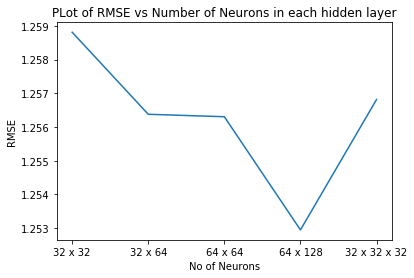

In [38]:
plt.plot(l2,l)
plt.title("PLot of RMSE vs Number of Neurons in each hidden layer")
plt.xlabel("No of Neurons")
plt.ylabel("RMSE")
plt.savefig('output/' +'rmse_hidden_layers.png')

In [39]:
user_counts=dataset['user_id'].value_counts()
less_prolific_users = user_counts.loc[user_counts <= 5].index.tolist()
test_data_less_prolific=test_dataset[(test_dataset.user_id.isin(less_prolific_users))]

In [40]:
X_wide_test_less_prolific = wide_preprocessor.transform(test_data_less_prolific)
X_deep_test_less_prolific = deep_preprocessor.fit_transform(test_data_less_prolific) 

In [41]:
y_pred=model_5.predict(X_wide=X_wide_test_less_prolific, X_deep=X_deep_test_less_prolific)
rmse = sqrt(mean_squared_error(test_data_less_prolific[target_col].values, y_pred))
print("Root-mean-square error for less prolific users = " + str(rmse))

predict: 100%|██████████| 143/143 [00:00<00:00, 188.72it/s]


Root-mean-square error for less prolific users = 1.2474996908479106


In [42]:
business_counts=dataset['business_id'].value_counts()
less_popular_business = business_counts.loc[business_counts <= 100].index.tolist()
test_data_less_popular=test_dataset[(test_dataset.business_id.isin(less_popular_business))]

In [43]:
X_wide_test_less_popular = wide_preprocessor.transform(test_data_less_popular)
X_deep_test_less_popular = deep_preprocessor.fit_transform(test_data_less_popular) 

In [45]:
y_pred=model_5.predict(X_wide=X_wide_test_less_popular, X_deep=X_deep_test_less_popular)
rmse = sqrt(mean_squared_error(test_data_less_popular[target_col].values, y_pred))
print("Root-mean-square error for less popular business = " + str(rmse))

predict: 100%|██████████| 165/165 [00:00<00:00, 165.45it/s]


Root-mean-square error for less popular business = 1.3657753490386966
